# Kartering av vattenvegetation i Vänern med satellitdata <br><br>![title](bilder/metria_logo.jpg)

Verktygen demonstrerar metoder för att extrahera potentiell vattenvegetation<br> ur en tidsserie med satellitbilder från Sentinel-2 med hjälp av Rymddatalabbet.<br> Resultat kan jämföras mot historisk utbredning av vattenvegetation i Vänern<br>som har karterats av Metria med satellitbilder från Landsat och SPOT.<br><br>Observera att separat login till Rymddatalabbet krävs för att använda verktyget som tänkt.<br><br>Verktygen är skrivna av [Metria AB](http://www.metria.se) på uppdrag av [Länsstyrelsen i Västra Götaland.](https://www.lansstyrelsen.se/vastra-gotaland.html)

----

<b>Vi börjar med att importera alla nödvändiga moduler:</b>

In [1]:
import datacube
from datacube.storage.masking import mask_invalid_data
from utils.data_cube_utilities.dc_display_map import display_map
import rasterio
import fiona
from osgeo import osr
import numpy
import xarray
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Markdown, display
import ipywidgets
from ipywidgets import Layout
from utils.metria_utilities import metria_utils

<br><b>Nedan väljer vi parametrar för vår analys:</b><br>
* <b>Analystyp</b> avgör vilket verktyg som utförs. I samtliga fall används [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) <br>för att hitta utbredningen av vattenvegetation.
Användaren kan plocka ut den sammantaget maximala utbredningen<br>under en tidsperiod. Användaren kan också jämföra den maximala utbredningen mot historiska utbredningar. <br>Endast en analystyp åt gången kan genomföras.<br><br>
* Under <b>Område</b> kan användaren antingen välja en kommun kring Vänern eller ladda upp en egen vektorfil<br>till Rymddatalabbet med en avgränsande polygon. Notera att endast en polygon får finnas i en fil med <br>en egendefinerad avgränsning samt att denna måste nudda Vänern för att fungera. Om en egen<br>avgränsning används måste sökväg/filnamn skrivas in under <b>Filnamn</b>, till exempel:  <i>filer/yta.shp</i><br><br>
* <b>Startdatum</b> samt <b>Slutdatum</b> används för att skapa ett spann av datum från vilket satellitbilder skall hämtas.<br><i>Notera att ett längre spann innebär längre bearbetningstider.</i> I Rymddatalabbet finns Sentinel-2 mellan 2018 och 2019.<br>I resultatet visas de faktiska datum mellan vilka satellitbilder finns tillgängliga inom spannet.<br><br>
* Användaren kan välja att <b>begränsa till </b>enskilda månader för analysen. Generellt är vattenvegetationen<br>synlig i satellidata mellan maj och september.<br><br>
* <b>Upplösning</b> avgör vilken version av Sentinel-2 data som används, dvs 10 eller 20 meters pixelstorlek. <br>Verktygen är tänkta att använda 10 meters upplösning, men då ett fullständigt arkiv med 10 meters upplösning <br>inte fanns tillgängligt i Rymddatalabbet när Metria skrev verktygen ges användaren möjlighet att byta mellan <br>olika dataset. Notera att upplösningen på resultat som sparas är alltid 10 meter oavsett källa.

In [2]:
metoder = ['Maximal utbredning av vattenvegetation under vald period', 'Maximal utbredning per månad under vald period',
             'Jämförelse av maximal utbredning mot 1988-2002', 'Jämförelse av maximal utbredning mot 2005-2013']

analysval = ipywidgets.Select(
    options=metoder,
    value=None,
    rows=4,
    description='Analystyp:',
    disabled=False,
    layout=Layout(width='40%')
)

display(analysval)

kommuner = ['Grums','Grästorp','Gullspång','Götene','Hammarö',
     'Karlstad','Kristinehamn','Lidköping','Mariestad',
     'Mellerud','Säffle','Vänersborg','Åmål','Egen polygon']

kommunval = ipywidgets.RadioButtons(
        options=kommuner,
        value=None,
        description='Område: ',
        disabled=False,
    )

display(kommunval)

avgransning = ipywidgets.Text(
    value='Om "Egen polygon" är vald, skriv in folder och namn på filen du vill använda för avgränsning',
    layout=Layout(width='40%'),
    description='Filnamn: ',
    disabled=False
)

display(avgransning)

startdatum = ipywidgets.DatePicker(
    description='Startdatum:',
    disabled=False
)

display(startdatum)

slutdatum = ipywidgets.DatePicker(
    description='Slutdatum:',
    disabled=False
)

display(slutdatum)


manader = ipywidgets.SelectMultiple(
    options=['Januari', 'Februari', 'Mars', 'April',
            'Maj', 'Juni', 'Juli', 'Augusti', 'September',
            'Oktober', 'November', 'December'],

    rows=13,
    description='Begränsa till: ',
    disabled=False
)

display(manader)

ps = ['10 meter', '20 meter']
pixel_size =  ipywidgets.RadioButtons(
        options=ps,
        value='20 meter',
        description='Upplösning: ',
        disabled=False,
    )

display(pixel_size)

Select(description='Analystyp:', layout=Layout(width='40%'), options=('Maximal utbredning av vattenvegetation …

RadioButtons(description='Område: ', options=('Grums', 'Grästorp', 'Gullspång', 'Götene', 'Hammarö', 'Karlstad…

Text(value='Om "Egen polygon" är vald, skriv in folder och namn på filen du vill använda för avgränsning', des…

DatePicker(value=None, description='Startdatum:')

DatePicker(value=None, description='Slutdatum:')

SelectMultiple(description='Begränsa till: ', options=('Januari', 'Februari', 'Mars', 'April', 'Maj', 'Juni', …

RadioButtons(description='Upplösning: ', index=1, options=('10 meter', '20 meter'), value='20 meter')

<br><b>När cellen nedan körs sparas våra val och visas på skärm:</b>

In [8]:
if (startdatum.value > slutdatum.value) is True:
    raise SystemExit('Startdatum för analysen är senare än slutdatum. Ändra i menyerna ovan')

kommun = kommunval.value

analysyta = {}

if not kommun == 'Egen polygon':
    with fiona.open('filer/strandlinje_per_kommun.gpkg', 'r', encoding='utf-8') as strandlinje_per_kommun:
        for k in strandlinje_per_kommun:
            if kommun in k['properties']['KOMMUNNAMN'].capitalize():
                bounds = fiona.bounds(k)
                bounds = tuple(map(lambda x: isinstance(x, float) and round(x, -1) or x, bounds))

                min_x = bounds[0]-1000
                min_y = bounds[1]-1000
                max_x = bounds[2]+1000
                max_y = bounds[3]+1000

                bounds = (min_x, min_y, max_x, max_y)

                analysyta[k['properties']['KOMMUNNAMN'].capitalize()] = bounds

                min_ll = metria_utils.omvandla(3006, 4236, bounds[0], bounds[1])[0:2]
                max_ll = metria_utils.omvandla(3006, 4236, bounds[2], bounds[3])[0:2]

                long = (min_ll[0], max_ll[0])
                lat = (min_ll[1], max_ll[1])
    
    opt = {'utan_s':' kommun', 'med_s':'s kommun'}
    if kommun.endswith('s') or kommun.endswith('e') or kommun.endswith('ö'):
        kommunstr = kommun+opt['utan_s']
    else:
        kommunstr = kommun+opt['med_s']

else:
    try:
        from shapely.geometry import Polygon
        with fiona.open(avgransning.value, 'r', encoding='utf-8') as boundingbox:
            for k in boundingbox:
                bounds = fiona.bounds(k)
                bounds = tuple(map(lambda x: isinstance(x, float) and round(x, -1) or x, bounds))

                min_x = bounds[0]
                min_y = bounds[1]
                max_x = bounds[2]
                max_y = bounds[3]                
                
                bounds = (min_x, min_y, max_x, max_y)
                
                egen_yta = Polygon([(bounds[0], bounds[3]), (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])])
                
                with fiona.open('filer/vanern_mask.gpkg', 'r', encoding='utf-8')  as vanern_strand:
                    for v in vanern_strand:
                        vanern_bounds = fiona.bounds(v)
                        vanern_box = Polygon([(vanern_bounds[0], vanern_bounds[3]), (vanern_bounds[2], vanern_bounds[3]), (
                            vanern_bounds[2], vanern_bounds[1]), (vanern_bounds[0], vanern_bounds[1])])
                
                if (egen_yta.intersects(vanern_box)) is False:
                    raise SystemExit('Filen du använder nuddar inte Vänern.')
                
                analysyta['Avgränsning'] = bounds

                min_ll = metria_utils.omvandla(3006, 4236, bounds[0], bounds[1])[0:2]
                max_ll = metria_utils.omvandla(3006, 4236, bounds[2], bounds[3])[0:2]

                long = (min_ll[0], max_ll[0])
                lat = (min_ll[1], max_ll[1])
        kommunstr = 'Egen avgränsning'
                          
    except Exception:
        raise SystemExit('Felaktig vektorfil definierad. Möjliga orsaker:\n\n-Filnamnet är inte korrekt skrivet.\n-Filen innehåller fler än en polygon.\n')

def tuple_till_str(tup): 
    str =  ', '.join(tup) 
    return str

manad = tuple_till_str(manader.value)

m = {'Januari':1, 'Februari':2, 'Mars':3, 'April':4, 'Maj':5, 
     'Juni':6, 'Juli':7, 'Augusti':8, 'September':9, 'Oktober':10,
     'November':11, 'December':12}

if 'Alla månader' in manader.value:
    m = [1,2,3,4,5,6,7,8,9,10,11,12]
else:
    mtemp = []
    for manad_ in manader.value:
        mtemp.append(m[manad_])
    m = mtemp

kriterier = {
        'x': (bounds[0], bounds[2]),
        'y': (bounds[1], bounds[3]),
        'crs': 'EPSG:3006',
        
        'output_crs': 'EPSG:3006',
        'resolution': (-10, 10),
        'time': (str(startdatum.value), str(slutdatum.value))
            }

print('\nSammanfattning av val:\n')
print(f'Typ av analys: {analysval.value}\nAnalysområde: {kommunstr}\nPeriod: {str(startdatum.value)} till {str(slutdatum.value)}\nMånader: {manad}\nUpplösning: {pixel_size.value}\n')

display_map(latitude = lat, longitude = long)


Sammanfattning av val:

Typ av analys: Maximal utbredning per månad under vald period
Analysområde: Hammarö kommun
Period: 2019-06-10 till 2019-10-15
Månader: Juni, Juli, Augusti, September
Upplösning: 20 meter



<br><b>Nedan hämtas satellitbilder från Rymddatalabbet, Om bilder hittats visas det första och sista datumet i tidsserien på skärm<br>Om inga bilder finns måste vi ändra våra sökkriterier</b><br><br>
Efter sökningen läggs data från samtliga satelliter ihop i datumordning och endast de tre spektrala band som behövs sparas.<br>Observera att molniga bilder inte påverkar analysen när flera bilder ingår då endast vegetationstäckta pixlar blir kvar efter bearbetningsstegen.

Bearbetar 1014 av 1014 bilder från s2b_sen2cor_sweref99tm_20
Sammanställer tidsserie

Hittade 68 bilder från vald period


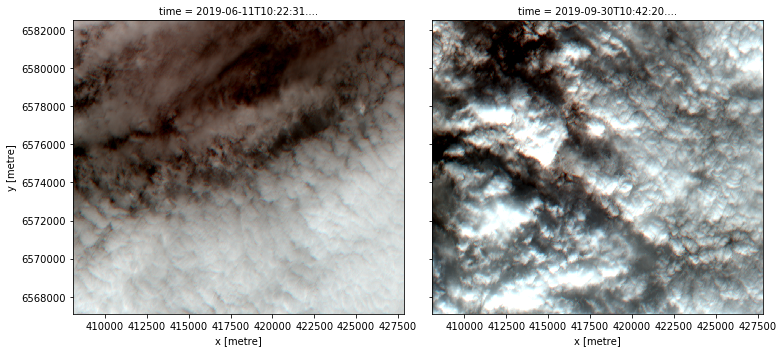

In [9]:
dc = datacube.Datacube()

if pixel_size.value == '10 meter':
    products = ['s2a_sen2cor_sweref99tm_10', 's2b_sen2cor_sweref99tm_10']
    nir_band = 'nir_1'

elif pixel_size.value == '20 meter':
    products = ['s2a_sen2cor_sweref99tm_20', 's2b_sen2cor_sweref99tm_20']
    nir_band = 'nir_2'
    
datasets = []
for prod in products:
    try:
        def progress(processed, total):
            print(f'\rBearbetar {processed} av {total} bilder från {prod}', end='', flush=True)
        dataset = dc.load(product=prod,
                          group_by='solar_day',
                          progress_cbk = progress,
                          **kriterier)        
        datasets.append(dataset)
    except ValueError:
        pass

print('\nSammanställer tidsserie')
satellitdata = xarray.concat(datasets, dim='time').sortby('time')
satellitdata = satellitdata[['green', 'red', nir_band]]

def reducera(man, mlista):
    return (man >= min(mlista)) & (man <= max(mlista))

if len(m) < 12:
    satellitdata = satellitdata.sel(time=reducera(satellitdata['time.month'], m))
else:
    pass

satellitdata = mask_invalid_data(satellitdata)

print(f'\nHittade {len(satellitdata.time)} bilder från vald period')
if len(satellitdata.time) == 0:
    print('Ändra datumintervallen ovan för att försöka igen')
else:
    if len(satellitdata.time) > 1:
        satellitdata[[nir_band, 'red', 'green']].isel(
            time = [0, -1]).to_array().plot.imshow(col = 'time', size = 5, robust = True)
    else:
        satellitdata[[nir_band, 'red', 'green']].isel(
            time = [0]).to_array().plot.imshow(col = 'time', size = 5, robust = True) 
        print('Om bilden är molnig påverkar detta analysen, ändra kritierierna i din sökning för att hitta fler bilder.')

<br><b>Om vi har hittat data kan vår valda analys genomföras nedan, resultatet visas på skärm visuellt och som graf.</b><br><br>
Grafen sparas automatiskt under "resultat" som png-bild. Notera att om samma analys görs om med samma område och datum kommer grafen skrivas över.

Figuren är sparad under "resultat/"


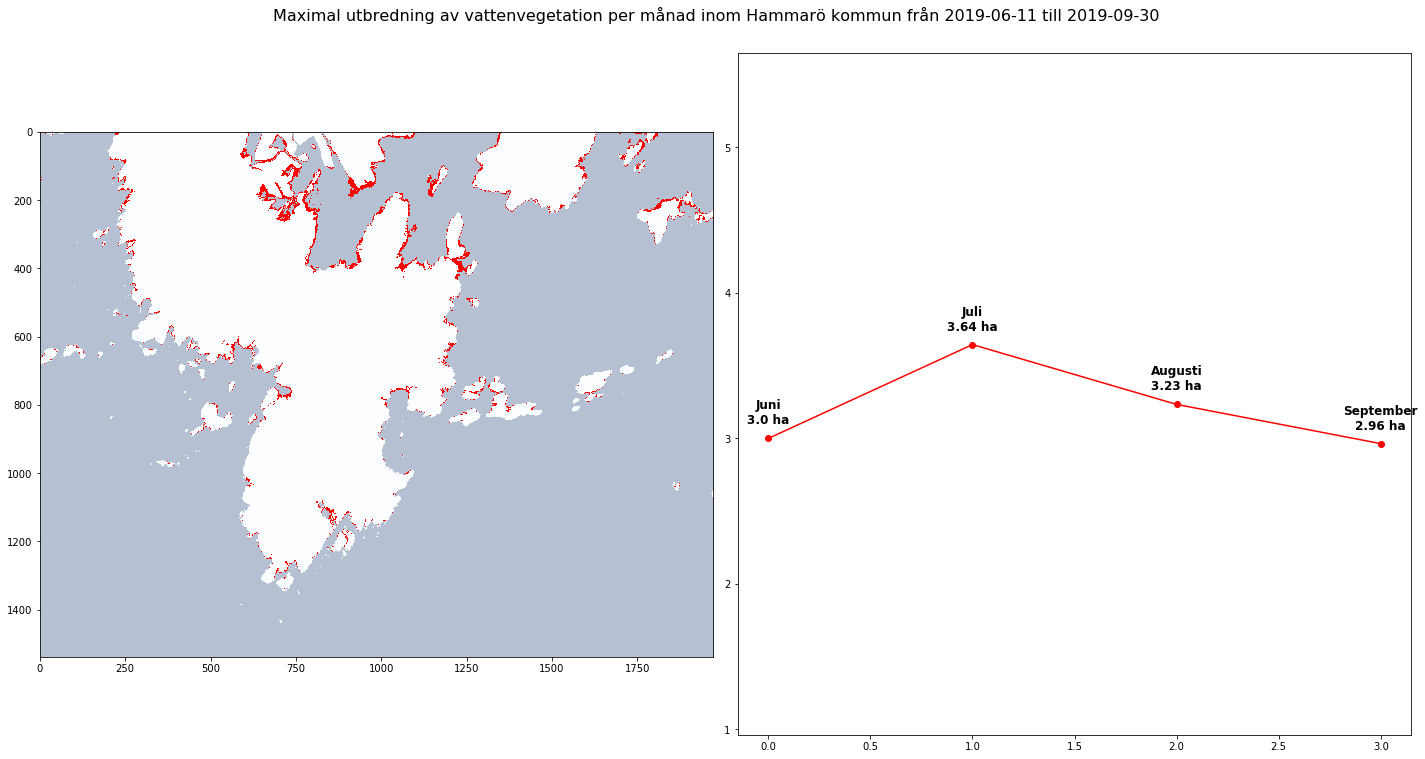

In [15]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def NDVI(nb, rb):
    return (normalize(nb) - normalize(rb)) / (normalize(nb) + normalize(rb))

def NDWI(gb, nb):
    return (normalize(gb) - normalize(nb)) / (normalize(gb) + normalize(nb))

colors = ['red', 'blue', 'purple', 'green', 'cyan', 'gold', 
          'darkred', 'orange', 'teal', 'olive', 'sienna', 'magenta']
res = kriterier['resolution']
start = str(satellitdata.time[0].values)[0:10]
slut = str(satellitdata.time[-1].values)[0:10]

greenband = satellitdata.green
redband = satellitdata.red

if pixel_size.value == '10 meter':
    nirband = satellitdata.nir_1
elif pixel_size.value == '20 meter':
    nirband = satellitdata.nir_2

ndvi = NDVI(nirband, redband)
ndwi = NDWI(greenband, nirband)

vm_lm, profile = metria_utils.polygon_till_raster('filer/vanern_mask.gpkg', bounds, res)
vm_ndwi = ndwi.max(dim='time').values

ndvi_threshold = 0.5
ndwi_threshold = 0.2

#Vald analys genomförs och resultat visualiseras på skärm:
if analysval.value == metoder[0]:
    
    prefix = 'Maximal_utbredning_av_vattenvegetation_'
    suffix = ''
    
    maximum = ndvi.max(dim='time').values
    maximum[vm_lm == 0] = 0
    maximum[vm_ndwi >= ndwi_threshold] = 0
    maximum[maximum <= ndvi_threshold] = 0
    maximum[maximum > 0] = 1
    resultat = numpy.copy(maximum)
    maximum[maximum == 0] = numpy.nan
    
    fig = plt.figure(figsize=(12,12))
    fig.suptitle(f'Maximal utbredning av vattenvegetation inom {kommunstr} från {start} till {slut}', fontsize=16)
    plt.imshow(vm_lm, cmap='Blues', alpha=0.3)
    plt.imshow(maximum, cmap='RdYlGn')
    plt.savefig(f'resultat/Maximal utbredning av vattenvegetation inom {kommunstr} från {start} till {slut}.png'.replace(' ', '_'))
    
elif analysval.value == metoder[1]:
    from random import shuffle
    
    prefix = 'Maximal_utbredning_av_vattenvegetation_per_månad_'
    suffix = ''    

    vmax = ndvi.max(dim='time').values
    vmax[vm_lm == 0] = 0
    vmax[vm_ndwi >= ndwi_threshold] = 0
    vmax[vmax <= ndvi_threshold] = 0
    vmax[vmax > 0] = 1
    vmax[vmax == 0] = numpy.nan
    
    ndvi_m = ndvi.groupby('time.month').max()
    ndwi_m = ndwi.groupby('time.month').max()
    
    vis_array = []
    vveg_array = []
    
    for m in ndvi_m:
        maximum = m.values
        maximum[vm_lm == 0] = 0
        maximum[vm_ndwi >= ndwi_threshold] = 0
        maximum[maximum <= ndvi_threshold] = 0
        maximum[maximum > 0] = 1
        resultat = numpy.copy(maximum)
        maximum[maximum == 0] = numpy.nan
        vis_array.append(maximum)
        vveg_array.append(resultat)
    
    vals = []
    for x in vveg_array:
        unique, counts = numpy.unique(x, return_counts=True)
        values = counts[1:]/10000
        vals.append(float(values))
        
    fig = plt.figure(figsize=(20,10))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    fig.suptitle(f'Maximal utbredning av vattenvegetation per månad inom {kommunstr} från {start} till {slut}', fontsize=16, y=1.05)
    ax0.imshow(vm_lm, cmap='Blues', alpha=0.3)
    ax0.imshow(vmax, cmap=matplotlib.colors.ListedColormap(colors))
    ax1.plot(vals, color='red', marker='o')
    ax1.set(ylim=(min(vals)-2, max(vals)+2))
    for v, i in enumerate(manader.value):
        ax1.text(v, vals[v]+.1, i+f'\n{round(vals[v], 2)} ha', color='black', ha='center', fontweight='bold', fontsize=12) 
    plt.tight_layout()
    plt.savefig(f'resultat/Maximal utbredning av vattenvegetation per månad inom {kommunstr} från {start} till {slut}.png'.replace(' ', '_'))
    
elif analysval.value == metoder[2]:

    prefix = 'Jämförelse_av_vattenvegetation_'
    suffix = '_mot_1988_2002'
    vattenveg_90tal, profile = metria_utils.raster_subset('filer/vattenveg_88_02_metria.tif', bounds, res)  
    resultat = metria_utils.jamforelse(ndvi, vattenveg_90tal, vm_lm, vm_ndwi, ndvi_threshold, ndwi_threshold)
    vis = numpy.copy(resultat)
    vis[vis == 0] = numpy.nan
    
    fig = plt.figure(figsize=(20,10))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    
    plt.suptitle(f'Skillnader i utbredning av vattenvegetation inom {kommunstr} från {start} till {slut} mot 1988-2002', fontsize=16, y=1.08)
    ax0.imshow(vm_lm, cmap='Blues', alpha=0.3)
    ax0.imshow(vis, cmap=matplotlib.colors.ListedColormap(colors))
    
    unique, counts = numpy.unique(resultat, return_counts=True)
    classes = ('Klass 1: Vattenvegetation \nendast 1988-2002', 
               'Klass 2: Vattenvegetation \nendast mellan valda datum', 'Klass 3: Vattenvegetation \ni båda datamängder')
    values = tuple(counts[1:]/10000)

    ax1.bar(classes, values, align='center', alpha=0.75, width=0.5, color=colors)
    for v, i in enumerate(values):
        ax1.text(v-0.075, i+0.05, str(round(i, 2))+' ha', color='black',  fontweight='bold', fontsize=12)
        
    plt.tight_layout()
    plt.savefig(f'resultat/Skillnader i utbredning av vattenvegetation inom {kommunstr} från {start} till {slut} mot 1988-2002.png'.replace(' ', '_'))
     
elif analysval.value == metoder[3]:

    prefix = 'Jämförelse_av_vattenvegetation_'
    suffix = '_mot_2005_2013'
    vattenveg_00tal, profile = metria_utils.raster_subset('filer/vattenveg_05_13_metria.tif', bounds, res)   

    resultat = metria_utils.jamforelse(ndvi, vattenveg_00tal, vm_lm, vm_ndwi, ndvi_threshold, ndwi_threshold)
    vis = numpy.copy(resultat)
    vis[vis == 0] = numpy.nan

    fig = plt.figure(figsize=(20,10))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)

    plt.suptitle(f'Skillnader i utbredning av vattenvegetation inom {kommunstr} från {start} till {slut} mot 2005-2013', fontsize=16, y=1.08)
    ax0.imshow(vm_lm, cmap='Blues', alpha=0.3)
    ax0.imshow(vis, cmap=matplotlib.colors.ListedColormap(colors))

    unique, counts = numpy.unique(resultat, return_counts=True)
    classes = ('Klass 1: Vattenvegetation \nendast 2005-2013', 
               'Klass 2: Vattenvegetation \nendast mellan valda datum', 'Klass 3: Vattenvegetation \ni båda datamängder')
    values = tuple(counts[1:]/10000)

    ax1.bar(classes, values, align='center', alpha=0.75, width=0.5, color=colors)
    for v, i in enumerate(values):
        ax1.text(v-0.075, i+0.05, str(round(i, 2))+' ha', color='black',  fontweight='bold', fontsize=12)  

    plt.tight_layout()
    plt.savefig(f'resultat/Skillnader i utbredning av vattenvegetation inom {kommunstr} från {start} till {slut} mot 2005-2013.png'.replace(' ', '_'))
    
print('Figuren är sparad under "resultat/"')

<br><b>När vi är nöjda med analysen kan vi spara resultatet (hamnar i foldern "resultat" till vänster):</b>

In [17]:
filnamn = ipywidgets.Text(
    value=prefix+f'{kommunstr}_{start}_{slut}{suffix}'.replace(' ', '_'),
    layout=Layout(width='70%'),
    description='Filnamn: ',
    disabled=False
)

display(filnamn)
print('\n')

knapp = ipywidgets.Button(
    description='Klicka här för att spara resultatet som en rasterfil',
    layout=Layout(width='40%'),
    button_style='',
    tooltip='Klicka här för att spara resultatet som en rasterfil',
    icon='check')
out = ipywidgets.Output()

def knapp_click(_):
    if not analysval.value == metoder[1]:
        with out:
            with rasterio.open(f'resultat/{filnamn.value}.tif', 'w', **profile) as dst:
                dst.write(resultat.astype(rasterio.uint8), 1)
                if analysval.value == metoder[2] or analysval.value == metoder[3]:
                    dst.write_colormap(
                        1, {0: (0, 0, 0, 255),
                        1: (255, 0, 0, 255),
                        2: (0, 0, 255, 255),
                        3: (150, 0, 255, 255)})
                else:
                    dst.write_colormap(
                    1, {0: (0, 0, 0, 255),
                        1: (255, 0, 0, 255)})
                print(f'Din fil är sparad under "resultat/"')
    else:
        with out:          
            for i in range(0, len(vveg_array)):
                with rasterio.open(f'resultat/{filnamn.value}_{manader.value[i]}.tif', 'w', **profile) as dst:
                    dst.write(vveg_array[i].astype(rasterio.uint8), 1)
            print(f'Dina filer är sparade under "resultat/"')

knapp.on_click(knapp_click)
ipywidgets.VBox([knapp,out])

Text(value='Maximal_utbredning_av_vattenvegetation_per_månad_Hammarö_kommun_2019-06-11_2019-09-30', descriptio…